In [47]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import Pool, cv,CatBoostRegressor

In [48]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission_df = pd.read_csv('sample_submission.csv')

In [49]:
train_df.shape

(16967, 21)

In [50]:
data = train_df[train_df['label'] == 1].drop(['label'], axis=1).dropna()

In [51]:
data.columns

Index(['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'meter_waiting_till_pickup', 'fare', 'pickup_date', 'pickup_hour',
       'pickup_minute', 'drop_date', 'drop_hour', 'drop_minute',
       'pick_cluster', 'is_more_than_one_day', 'distance_km', 'fare_per_km',
       'pickup_timeslot', 'day_of_week', 'is_weekday', 'cal_time_difference'],
      dtype='object')

In [52]:
cat_features = ['pick_cluster','is_more_than_one_day','pickup_timeslot',
       'day_of_week', 'is_weekday']

features = ['additional_fare','duration', 'meter_waiting','meter_waiting_fare',
       'meter_waiting_till_pickup', 'pick_cluster', 'is_more_than_one_day', 'distance_km','pickup_timeslot',
       'day_of_week', 'is_weekday']

In [53]:
X = data[features]
y = data['fare'].values

In [54]:
train_df_X = train_df[features]
train_df_pool = Pool(data=train_df_X,cat_features=cat_features)
test_df_X = test_df[features]
test_df_pool = Pool(data=test_df_X,cat_features=cat_features)

In [55]:
train_df_preds = np.zeros(train_df.shape[0])
test_df_preds = np.zeros(test_df.shape[0])

In [56]:
params = {
    'loss_function':'RMSE',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'RMSE'
}

In [57]:
kf = KFold(n_splits=3)

In [58]:
validation_scores = []
models = []
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostRegressor(**params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    validation_score = model.best_score_['validation']['RMSE']
    print('Validation RMSE',validation_score)
    validation_scores.append(validation_score)
    models.append(model)
    
    train_df_preds += model.predict(train_df_pool)
    test_df_preds += model.predict(test_df_pool)

Learning rate set to 0.071592
0:	learn: 354.7152061	test: 268.1502429	best: 268.1502429 (0)	total: 5.01ms	remaining: 5s
10:	learn: 271.5126332	test: 195.1736196	best: 195.1736196 (10)	total: 54.2ms	remaining: 4.87s
20:	learn: 222.6522465	test: 164.9022783	best: 164.9022783 (20)	total: 99.9ms	remaining: 4.66s
30:	learn: 187.7155907	test: 146.9843589	best: 146.9843589 (30)	total: 152ms	remaining: 4.75s
40:	learn: 160.3850089	test: 137.1071114	best: 137.1071114 (40)	total: 207ms	remaining: 4.84s
50:	learn: 139.0743900	test: 131.6432025	best: 131.6432025 (50)	total: 279ms	remaining: 5.19s
60:	learn: 122.7631824	test: 127.4373651	best: 127.4373651 (60)	total: 331ms	remaining: 5.09s
70:	learn: 109.2646698	test: 121.8992014	best: 121.8992014 (70)	total: 378ms	remaining: 4.94s
80:	learn: 99.3614795	test: 119.7227717	best: 119.7227717 (80)	total: 442ms	remaining: 5.02s
90:	learn: 91.2848868	test: 117.4499264	best: 117.4499264 (90)	total: 489ms	remaining: 4.89s
100:	learn: 85.5804327	test: 116.5

In [59]:
np.mean(validation_scores), np.std(validation_scores)

(178.75587482118488, 91.42413957178184)

In [60]:
best_model = models[np.argmax(validation_scores)]

In [61]:
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,duration,42.921846
1,distance_km,36.690306
2,is_more_than_one_day,8.619333
3,meter_waiting_fare,4.188275
4,meter_waiting_till_pickup,3.264051
5,meter_waiting,1.928844
6,additional_fare,0.660016
7,day_of_week,0.624764
8,pickup_timeslot,0.545443
9,pick_cluster,0.371950


In [62]:
train_df['predicted_fare'] = train_df_preds/3
test_df['predicted_fare'] = test_df_preds/3

In [63]:
train_df['predicted_fare_difference'] = train_df['fare'] - train_df['predicted_fare']
test_df['predicted_fare_difference'] = test_df['fare'] - test_df['predicted_fare']

In [64]:
train_df['predicted_fare_difference_per_fare'] = train_df['predicted_fare_difference'] / (train_df['fare']+1)
test_df['predicted_fare_difference_per_fare'] = test_df['predicted_fare_difference']  / (test_df['fare']+1)

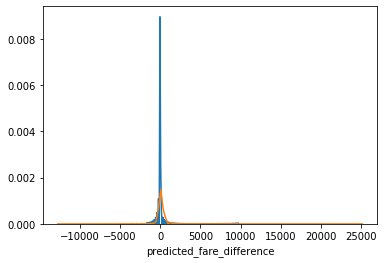

In [65]:
sns.distplot(train_df[train_df['label']==1]['predicted_fare_difference'], hist=False)
sns.distplot(train_df[train_df['label']==0]['predicted_fare_difference'], hist=False)

In [66]:
train_df[train_df['label']==1]['predicted_fare_difference'].describe()

count    15441.000000
mean         0.597703
std        103.397671
min      -1642.276725
25%        -25.783882
50%         -8.442351
75%         16.428180
max       9775.864941
Name: predicted_fare_difference, dtype: float64

In [67]:
train_df[train_df['label']==0]['predicted_fare_difference'].describe()

count     1526.000000
mean       125.831495
std       1418.483290
min     -12533.361989
25%        -76.316972
50%         58.159160
75%        297.935952
max      24904.049328
Name: predicted_fare_difference, dtype: float64

In [68]:
# train_df = train_df.drop(['predicted_fare'],axis=1)
# test_df = test_df.drop(['predicted_fare'],axis=1)

In [69]:
train_df.to_csv('train_df_reg.csv',index=False)
test_df.to_csv('test_df_reg.csv',index=False)